In [1]:
import os
import numpy as np
import tensorflow as tf
from datasets import data as dataset
from models.nn import YOLO as ConvNet
from learning.evaluators import RecallEvaluator as Evaluator
from learning.utils import draw_pred_boxes, predict_nms_boxes, convert_boxes
import cv2
import glob

In [2]:
""" 1. Load dataset """
root_dir = os.path.join('data/face')
test_dir = os.path.join(root_dir, 'test')
IM_SIZE = (416, 416)
NUM_CLASSES = 1

In [3]:
# Load test set
X_test, y_test = dataset.read_data(test_dir, IM_SIZE)
test_set = dataset.DataSet(X_test, y_test)


In [4]:
""" 2. Set test hyperparameters """
anchors = dataset.load_json(os.path.join(test_dir, 'anchors.json'))
class_map = dataset.load_json(os.path.join(test_dir, 'classes.json'))
nms_flag = True
hp_d = dict()
hp_d['batch_size'] = 16
hp_d['nms_flag'] = nms_flag

In [5]:
""" 3. Build graph, load weights, initialize a session and start test """
# Initialize
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

model = ConvNet([IM_SIZE[0], IM_SIZE[1], 3], NUM_CLASSES, anchors, grid_size=(IM_SIZE[0]//32, IM_SIZE[1]//32))
evaluator = Evaluator()
saver = tf.train.Saver()

sess = tf.Session(graph=graph, config=config)
saver.restore(sess, '/tmp/model.ckpt')
test_y_pred = model.predict(sess, test_set, **hp_d)
test_score = evaluator.score(test_set.labels, test_y_pred)

print('Test performance: {}'.format(test_score))

layer1.shape [None, 208, 208, 32]
layer2.shape [None, 104, 104, 64]
layer3.shape [None, 104, 104, 128]
layer4.shape [None, 104, 104, 64]
layer5.shape [None, 52, 52, 128]
layer6.shape [None, 52, 52, 256]
layer7.shape [None, 52, 52, 128]
layer8.shape [None, 26, 26, 256]
layer9.shape [None, 26, 26, 512]
layer10.shape [None, 26, 26, 256]
layer11.shape [None, 26, 26, 512]
layer12.shape [None, 26, 26, 256]
layer13.shape [None, 13, 13, 512]
layer14.shape [None, 13, 13, 1024]
layer15.shape [None, 13, 13, 512]
layer16.shape [None, 13, 13, 1024]
layer17.shape [None, 13, 13, 512]
layer18.shape [None, 13, 13, 1024]
layer19.shape [None, 13, 13, 1024]
layer20.shape [None, 13, 13, 1024]
layer21.shape [None, 13, 13, 1280]
layer22.shape [None, 13, 13, 1024]
pred.shape [None, 13, 13, 5, 6]
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Test performance: 0.8552278820375335


In [6]:
""" 4. Draw boxes on image """
draw_dir = os.path.join(test_dir, 'draws') # FIXME
if not os.path.isdir(draw_dir):
    os.mkdir(draw_dir)
im_dir = os.path.join(test_dir, 'images') # FIXME
im_paths = []
im_paths.extend(glob.glob(os.path.join(im_dir, '*.jpg')))
for idx, (img, y_pred, im_path) in enumerate(zip(test_set.images, test_y_pred, im_paths)):
    name = im_path.split('/')[-1]
    draw_path =os.path.join(draw_dir, name)
    if nms_flag:
        bboxes = predict_nms_boxes(y_pred, conf_thres=0.5, iou_thres=0.5)
    else:
        bboxes = convert_boxes(y_pred)
    bboxes = bboxes[np.nonzero(np.any(bboxes > 0, axis=1))]
    boxed_img = draw_pred_boxes(img, bboxes, class_map)
    cv2.imwrite(draw_path, boxed_img)

In [7]:
draw_path

'data/face/test/draws/2002_07_20_big_img_548.jpg'

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

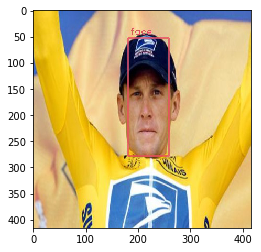

In [14]:
image = mpimg.imread(draw_path)
plt.imshow(image)